# Household Power Consumption ML Predictor

This notebook will focus on creating a ML model that aims to predict a household power consumption. This will also be the final project for the Machine Learning Algorithms course of IPCA - Aplied Machine Learning course. 

The project requirements paper is available in this repository under the name of "Practical_Assessment_MAAI_MLA_2025_2026.pdf".

Course professor [*lufer*](https://github.com/luferIPCA)

Notebook made by [*Álvaro Terroso*](https://github.com/alvaroterroso)

Dataset is available at [*UC Irvine*](https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Dataset public informations and import

This is a public dataset found on kaggle, the original authors are [*Georges Hébrail*](https://www.linkedin.com/in/georges-hebrail-582a0813/?originalSubdomain=fr) and [*Alice Bérard*](https://www.linkedin.com/in/aliceberard/). 

This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010.

As the dataset is in txt format, we will need first to convert it to csv format.

In [3]:
# Import from the original TXT (semicolon-separated) and parse Date+Time
df = pd.read_csv(
	"household_power_consumption.txt",
	sep=";",
	na_values=["?", "NA", ""],
	parse_dates={"Datetime": ["Date", "Time"]}, # Merge Date and Time into Datetime
	infer_datetime_format=True, # Speed up parsing
	low_memory=False, # Avoid dtype warning
 	dayfirst=True # European date format
)

/var/folders/bs/4chzcy9x1p7b7wz85_sqn_3r0000gn/T/ipykernel_88289/198833453.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
/var/folders/bs/4chzcy9x1p7b7wz85_sqn_3r0000gn/T/ipykernel_88289/198833453.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


## Dataset details

In [4]:
df.shape

(2075259, 8)

We got a data with 2 Million records, and 8 columns.

In [5]:
df.head(10)

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
5,2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0
6,2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0
7,2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0
8,2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0.0,1.0,17.0
9,2006-12-16 17:33:00,3.662,0.510,233.86,15.8,0.0,2.0,16.0


## Column meanings and purpose in the dataset

This dataset contains **minute-level electricity measurements** from a single household (Sceaux, France), collected over a long period (Dec 2006–Nov 2010). Each row is one timestamp, and the variables describe the household’s electrical load both at an overall level and for three specific appliance groups (sub-meterings). The dataset also contains a small proportion of missing measurements (~1.25%), meaning some timestamps exist but the sensor values may be absent.

### Datetime
- **Meaning:** The exact date and time of the measurement (one-minute resolution).
- **Purpose:** Enables time-series analysis and feature engineering (hour, day of week, seasonality, holidays), and supports forecasting (next minute/hour/day consumption).

### Global_active_power
- **Meaning:** Total **active power** consumed by the household at that minute (typically in **kW**).
- **Purpose:** This is usually the **main target variable** for forecasting/monitoring because it represents the real power used by appliances. It can also be converted into energy and cost estimates over time.

### Global_reactive_power
- **Meaning:** Total **reactive power** at that minute (typically in **kVAR**).
- **Purpose:** Helps characterize the type of electrical load (inductive/capacitive appliances). It can provide additional predictive signal and insight into efficiency/power quality, even though it is not “useful work” energy.

### Voltage
- **Meaning:** The household supply **voltage** at that minute (in **V**).
- **Purpose:** Captures grid/supply fluctuations that can affect current draw and power consumption. Useful for diagnosing abnormal behaviour and improving prediction accuracy.

### Global_intensity
- **Meaning:** Total **current intensity** drawn by the household at that minute (in **A**).
- **Purpose:** Another view of instantaneous load. Since power is related to voltage and current, this feature is strongly tied to consumption peaks and can help models detect high-load periods.

### Sub_metering_1
- **Meaning:** **Active energy** consumed by the **kitchen** appliance group during that minute (in **Wh**).
- **Purpose:** Provides appliance-group breakdown of consumption, supporting more detailed behavioural analysis (cooking patterns) and enabling models to learn which activities drive peaks.

### Sub_metering_2
- **Meaning:** **Active energy** consumed by the **laundry room** appliance group during that minute (in **Wh**).
- **Purpose:** Helps identify energy usage linked to washing/drying routines and supports targeted insights (e.g., shifting laundry to cheaper hours).

### Sub_metering_3
- **Meaning:** **Active energy** consumed by **electric water heating and air conditioning** during that minute (in **Wh**).
- **Purpose:** Often linked to strong **seasonal effects** (heating/cooling). It is key for analysing winter/summer consumption patterns and improving forecasting.


## Null values analysis

In [6]:
df.isnull().sum()

Datetime                     0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

After this null assessment, we found that 25979 recorda are null.

Regarding the type of minute information the dataset provides us, and the fact that these records represent 1.25% of the dataset, they will be deleted.

In [7]:
# Drop rows with any null values
df = df.dropna().reset_index(drop=True)

# Quick check
df.isnull().sum()

Datetime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [8]:
df.shape

(2049280, 8)

## Duplicated analysis

In [9]:
df.duplicated().sum()

0

This dataset has no duplicate data.

## Reduce dataframe
Currently the datataframe has registered values every minute. This explains the size amount and could introduce some noise during the training.

To correct this, we will convert the datafram to hourly registers.

In [10]:
# garantir datetime
df["Datetime"] = pd.to_datetime(df["Datetime"])

# ordenar e usar Datetime como índice
df = df.sort_values("Datetime").set_index("Datetime")

# converter potência (kW) em energia por minuto (kWh)
df["energy_kwh_min"] = df["Global_active_power"] / 60

# agregação por hora
hourly_df = df.resample("H").agg({
    "energy_kwh_min": "sum",          # TARGET (kWh por hora)
    "Global_reactive_power": "mean",
    "Voltage": "mean",
    "Global_intensity": "mean",
    "Sub_metering_1": "sum",
    "Sub_metering_2": "sum",
    "Sub_metering_3": "sum"
})

# renomear target
hourly_df = hourly_df.rename(columns={
    "energy_kwh_min": "target_kwh_hour"
})

# voltar a ter Datetime como coluna
hourly_df = hourly_df.reset_index()

hourly_df.head(10)


/var/folders/bs/4chzcy9x1p7b7wz85_sqn_3r0000gn/T/ipykernel_88289/167088348.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_df = df.resample("H").agg({


,Datetime,target_kwh_hour,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:00:00,2.533733,0.229000,234.643889,18.100000,0.0,19.0,607.0
1,2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,403.0,1012.0
2,2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,86.0,1001.0
3,2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.0,1007.0
4,2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,25.0,1033.0
5,2006-12-16 22:00:00,2.200133,0.056167,238.760000,9.523333,0.0,8.0,266.0
6,2006-12-16 23:00:00,2.061600,0.071433,240.619667,8.896667,0.0,5.0,0.0
7,2006-12-17 00:00:00,1.882467,0.102433,240.961833,8.126667,0.0,28.0,0.0
8,2006-12-17 01:00:00,3.349400,0.136933,240.448333,14.246667,0.0,1514.0,0.0
9,2006-12-17 02:00:00,1.587267,0.078233,245.818667,6.870000,0.0,34.0,0.0


In [11]:
hourly_df.shape

(34589, 8)

Now we got 34k records, which will give us plenty of information to work with.

## Create new features

For this project the goal is to predict the household energy consumption, and the dataset does not include some relevant features, such as **season**, **day of the week** or **if it is weekend**, among others.

For this stage, we will focus on creating categorical features for this, that in the future will be transformed to binary.

In [12]:
hourly_df["Datetime"] = pd.to_datetime(hourly_df["Datetime"])

# create MM-DD format to compare using time intervals
md = hourly_df["Datetime"].dt.strftime("%m-%d")

hourly_df["season"] = np.select(
    [
        (md >= "03-20") & (md <= "06-20"),  # Spring
        (md >= "06-21") & (md <= "09-22"),  # Summer
        (md >= "09-23") & (md <= "12-20"),  # Fall
    ],
    ["spring", "summer", "fall"],
    default="winter"
)

# is_weekend
hourly_df["is_weekend"] = (hourly_df["Datetime"].dt.dayofweek >= 5).astype(int)

hourly_df.head(10)

,Datetime,target_kwh_hour,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,season,is_weekend
0,2006-12-16 17:00:00,2.533733,0.229000,234.643889,18.100000,0.0,19.0,607.0,fall,1
1,2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,403.0,1012.0,fall,1
2,2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,86.0,1001.0,fall,1
3,2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.0,1007.0,fall,1
4,2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,25.0,1033.0,fall,1
5,2006-12-16 22:00:00,2.200133,0.056167,238.760000,9.523333,0.0,8.0,266.0,fall,1
6,2006-12-16 23:00:00,2.061600,0.071433,240.619667,8.896667,0.0,5.0,0.0,fall,1
7,2006-12-17 00:00:00,1.882467,0.102433,240.961833,8.126667,0.0,28.0,0.0,fall,1
8,2006-12-17 01:00:00,3.349400,0.136933,240.448333,14.246667,0.0,1514.0,0.0,fall,1
9,2006-12-17 02:00:00,1.587267,0.078233,245.818667,6.870000,0.0,34.0,0.0,fall,1


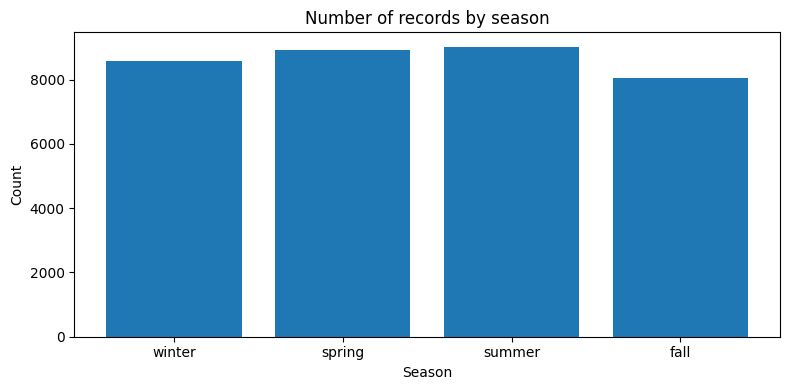

In [13]:
# Histogram / bar chart: records por estação
season_order = ["winter", "spring", "summer", "fall"]

season_counts = (
    hourly_df["season"]
    .astype(str)
    .value_counts()
    .reindex(season_order)
    .fillna(0)
)

plt.figure(figsize=(8, 4))
plt.bar(season_counts.index, season_counts.values)
plt.title("Number of records by season")
plt.xlabel("Season")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

We got a good, balance distributions of season.

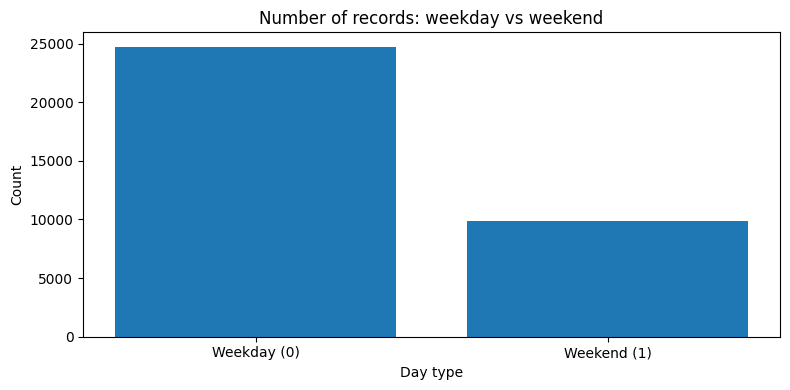

In [14]:
# Histogram / bar chart: semana vs fim de semana
weekend_counts = (
    hourly_df["is_weekend"]
    .value_counts()
    .reindex([0, 1])
    .fillna(0)
)

labels = ["Weekday (0)", "Weekend (1)"]

plt.figure(figsize=(8, 4))
plt.bar(labels, weekend_counts.values)
plt.title("Number of records: weekday vs weekend")
plt.xlabel("Day type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Has expected, the amount of weekdays is way bigger then the weekend amount.

In [15]:
# one-hot encoding (create season_spring, season_summer, season_fall, columns fall will be the default, but we will rename it)
hourly_df = pd.get_dummies(hourly_df, columns=["season"], prefix="season", drop_first=True)

hourly_df.head(10)

,Datetime,target_kwh_hour,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,is_weekend,season_spring,season_summer,season_winter
0,2006-12-16 17:00:00,2.533733,0.229000,234.643889,18.100000,0.0,19.0,607.0,1,False,False,False
1,2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,403.0,1012.0,1,False,False,False
2,2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,86.0,1001.0,1,False,False,False
3,2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.0,1007.0,1,False,False,False
4,2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,25.0,1033.0,1,False,False,False
5,2006-12-16 22:00:00,2.200133,0.056167,238.760000,9.523333,0.0,8.0,266.0,1,False,False,False
6,2006-12-16 23:00:00,2.061600,0.071433,240.619667,8.896667,0.0,5.0,0.0,1,False,False,False
7,2006-12-17 00:00:00,1.882467,0.102433,240.961833,8.126667,0.0,28.0,0.0,1,False,False,False
8,2006-12-17 01:00:00,3.349400,0.136933,240.448333,14.246667,0.0,1514.0,0.0,1,False,False,False
9,2006-12-17 02:00:00,1.587267,0.078233,245.818667,6.870000,0.0,34.0,0.0,1,False,False,False


We created 3 new binary features `season_spring`, `season_summer` and `season_winter`. `season_fall` does not exist because it is the default value (all other 3 are false)

## Training Split

In [ ]:
hourly_df = hourly_df.sort_values("Datetime")

# garantir datetime
hourly_df["Datetime"] = pd.to_datetime(hourly_df["Datetime"])

# datas limites
start = hourly_df["Datetime"].min()

# corte: 3 anos depois do início
cutoff = start + pd.DateOffset(years=3)

train = hourly_df[hourly_df["Datetime"] < cutoff]
test  = hourly_df[hourly_df["Datetime"] >= cutoff]

val_cutoff = train["Datetime"].min() + pd.DateOffset(years=2, months=6)

train2 = train[train["Datetime"] < val_cutoff]
val    = train[train["Datetime"] >= val_cutoff]

print("Train period:", train2["Datetime"].min(), "->", train2["Datetime"].max())
print("Validation period:", val["Datetime"].min(), "->", val["Datetime"].max())
print("Test  period:", test["Datetime"].min(),  "->", test["Datetime"].max())
print("Train size:", len(train), "Test size:", len(test))

X_train = train.drop(columns=["target_kwh_hour"])
y_train = train["target_kwh_hour"]

X_val = val.drop(columns=["target_kwh_hour"])
y_val = val["target_kwh_hour"]

X_test  = test.drop(columns=["target_kwh_hour"])
y_test  = test["target_kwh_hour"]

Train period: 2006-12-16 17:00:00 -> 2009-06-16 16:00:00
Validation period: 2009-06-16 17:00:00 -> 2009-12-16 16:00:00
Test  period: 2009-12-16 17:00:00 -> 2010-11-26 21:00:00
Train size: 26304 Test size: 8285
